In [1]:
import os
import random
import numpy as np
import torch 
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.utils.data import DataLoader, random_split, Subset

# Define the device and data repository
device = 'cpu'
data_dir = 'data/'

In [2]:
# Some widely-used datasets (like MNIST) can be downloaded directly from pytorch.
# There are also specific commands to create a dataset object (without having to do it manually)

# Choose one (or several) transform(s) to preprocess the data
data_transforms = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

# Create a Dataset (you can download the data by setting'download=True')
train_data = torchvision.datasets.MNIST(data_dir, train=True, download=True, transform=data_transforms)
test_data = torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=data_transforms)
num_classes = len(train_data.classes)

# We are not going to work with the full dataset (which is very big), so we only keep small train and test subsets.
train_data = Subset(train_data, torch.arange(400))
test_data = Subset(test_data, torch.arange(50))

/home/paul/.local/lib/python3.6/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([1, 28, 28])


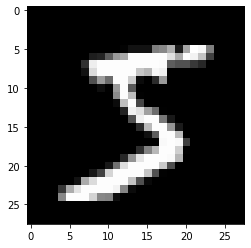

Image label =  5


In [3]:
# Fetch one data pair (one image and the corresponding label)
image, label = train_data[0]
print(image.shape)
plt.imshow(image[0].numpy(), cmap='gray')
plt.show()
print('Image label = ', label)

In [4]:
# TO DO: create two dataloaders (for the training and testing subsets), with a batch_size = 8, and print the number of batches in the training subset
batch_size = 8
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

print('Number of batches in the training subset: ', len(train_dataloader))

Number of batches in the training subset:  50


In [5]:
# Here we define the MLP classifier model: it has two layers and a non-linear activation function.

class MLPClassif(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, act_fn):
        super(MLPClassif, self).__init__()
        
        # TO DO: define the two linear layers and the activation function
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, output_size)
        self.activation_fn = act_fn
    
    def forward(self, x):
        
        # TO DO: write the 'forward' method, which computes the output y from the input x
        # It should apply: layer1, the activation function, layer 2, and the activation function again
        h = self.layer1(x)
        h = self.activation_fn(h)
        h = self.layer2(h)
        y = self.activation_fn(h)
        
        return y

In [6]:
# To DO: Create an MLP with a hidden size of 100 and a non-linear activation function that is appropriate for classification
# https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity
# hint: the inputs of the model are vectorized images

input_size = train_data[0][0][0].shape[0]*train_data[0][0][0].shape[1]
hidden_size = 100
act_fn = nn.Sigmoid()
output_size = num_classes

model = MLPClassif(input_size, hidden_size, output_size, act_fn)

# A useful command to print the total number of parameters in the model
print('Total number of parameters: ', sum(p.numel() for p in model.parameters()))

Total number of parameters:  79510


In [7]:
# Training function: it's very similar to what we did in lab2.1
# The difference is that now we process batches of data instead of the whole dataset at each epoch

def training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device='cpu', verbose=True):

    # Copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches using the dataloader
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # TO DO: write the training procedure for each batch. This should consist of:
            # - vectorizing the images (shape should be (batch_size, input_size))
            # - copy the data (images and labels) to the device
            # - apply the forward pass (calculate the predicted labels from the input images)
            # - use the 'backward' method to compute the gradients
            # - apply the gradient descent algorithm
            # Also think of updating the loss at the current epoch
            
            # Prepare the inputs and labels
            images = images.reshape(images.shape[0], -1)
            images = images.to(device)
            labels = labels.to(device)
            
            # Forward pass
            labels_predicted = model(images)
            
            # Backpropagation
            loss = loss_fn(labels_predicted, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)
        if verbose:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss_current_epoch))
        
    return model, loss_all_epochs

In [8]:
# TO DO: Train the model (100 epochs, learning rate of 0.01) using a loss function that is appropriate for classification
# https://pytorch.org/docs/stable/nn.html#loss-functions
# After training, save the model parameters and display the loss over epochs

num_epochs = 100
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()

model, loss_all_epochs = training_mlp_classifier(model, train_dataloader, num_epochs, loss_fn, learning_rate, device)
torch.save(model.state_dict(), 'model_mlp_classif.pt')

plt.plot(loss_all_epochs)
plt.show()

Epoch [1/100], Loss: 114.9107
Epoch [2/100], Loss: 114.3659
Epoch [3/100], Loss: 113.8481
Epoch [4/100], Loss: 113.3459
Epoch [5/100], Loss: 112.8715


KeyboardInterrupt: 

In [9]:
# Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop

def eval_mlp_classifier(model, eval_dataloader, device='cpu'):

    # Copy the model to the device
    model.to(device)
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval() 

    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:

            # Get the predicted labels classes
            images = images.reshape(images.shape[0], -1).to(device)
            labels = labels.to(device)
            y_predicted = model(images)
            
            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)
            
            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
    
    accuracy = 100 * correct_labels / total_labels
    
    return accuracy

In [10]:
# TO DO: Evaluate the model on the test set (instanciate the model, load the trained parameters and use the
# evaluation function). Display the accuracy on the test set.

model = MLPClassif(input_size, hidden_size, num_classes, act_fn)
model.load_state_dict(torch.load('model_mlp_classif.pt'))
accuracy = eval_mlp_classifier(model, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  84.0 %


In [11]:
# BONUS WORK: Train an MLP classifier, but use the negative log-likelihood loss
# https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html#torch.nn.NLLLoss
# After training, evaluate it on the test set and print the accuracy

model_nll = MLPClassif(input_size, hidden_size, num_classes, act_fn)
loss_fn = nn.NLLLoss()
model_nll, _ = training_mlp_classifier(model_nll, train_dataloader, num_epochs, loss_fn, learning_rate, device, verbose=False)
accuracy = eval_mlp_classifier(model_nll, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Accuracy of the network on the test images:  48.0 %


In [10]:
# BONUS WORK: Train an MLP classifier (using the binary cross entropy again) but with the RELU activation function
# After training, evaluate it on the test set and print the accuracy

model_relu = MLPClassif(input_size, hidden_size, num_classes, nn.ReLU())
loss_fn = nn.CrossEntropyLoss()
model_relu, _ = training_mlp_classifier(model_relu, train_dataloader, num_epochs, loss_fn, learning_rate, device, verbose=True)
accuracy = eval_mlp_classifier(model_relu, test_dataloader, device)
print('Accuracy of the network on the test images: ', accuracy, '%')

Epoch [1/100], Loss: 103.5501
Epoch [2/100], Loss: 75.2498
Epoch [3/100], Loss: 59.3151
Epoch [4/100], Loss: 51.3103
Epoch [5/100], Loss: 44.5904
Epoch [6/100], Loss: 38.9240
Epoch [7/100], Loss: 33.9884
Epoch [8/100], Loss: 28.8108
Epoch [9/100], Loss: 25.7331
Epoch [10/100], Loss: 23.0678
Epoch [11/100], Loss: 21.3380
Epoch [12/100], Loss: 19.8842
Epoch [13/100], Loss: 18.6165
Epoch [14/100], Loss: 17.7844
Epoch [15/100], Loss: 16.9837
Epoch [16/100], Loss: 16.2848
Epoch [17/100], Loss: 15.7260
Epoch [18/100], Loss: 15.1600
Epoch [19/100], Loss: 14.8158
Epoch [20/100], Loss: 14.4335
Epoch [21/100], Loss: 14.0797
Epoch [22/100], Loss: 13.8166
Epoch [23/100], Loss: 13.5738
Epoch [24/100], Loss: 13.3257
Epoch [25/100], Loss: 13.1416
Epoch [26/100], Loss: 12.9493
Epoch [27/100], Loss: 12.7793
Epoch [28/100], Loss: 12.6475
Epoch [29/100], Loss: 12.5152
Epoch [30/100], Loss: 12.3995
Epoch [31/100], Loss: 12.2950
Epoch [32/100], Loss: 12.2159
Epoch [33/100], Loss: 12.1212
Epoch [34/100], Lo

Epoch [1/100], Training loss: 103.0371 ; Validation accuracy: 12.0000
Epoch [2/100], Training loss: 102.6118 ; Validation accuracy: 16.0000
Epoch [3/100], Training loss: 102.2008 ; Validation accuracy: 22.0000
Epoch [4/100], Training loss: 101.7991 ; Validation accuracy: 22.0000
Epoch [5/100], Training loss: 101.4072 ; Validation accuracy: 22.0000
Epoch [6/100], Training loss: 101.0265 ; Validation accuracy: 20.0000
Epoch [7/100], Training loss: 100.6484 ; Validation accuracy: 26.0000
Epoch [8/100], Training loss: 100.2705 ; Validation accuracy: 30.0000
Epoch [9/100], Training loss: 99.8984 ; Validation accuracy: 34.0000
Epoch [10/100], Training loss: 99.5310 ; Validation accuracy: 42.0000
Epoch [11/100], Training loss: 99.1611 ; Validation accuracy: 48.0000
Epoch [12/100], Training loss: 98.7825 ; Validation accuracy: 48.0000
Epoch [13/100], Training loss: 98.4028 ; Validation accuracy: 50.0000
Epoch [14/100], Training loss: 98.0290 ; Validation accuracy: 52.0000
Epoch [15/100], Train

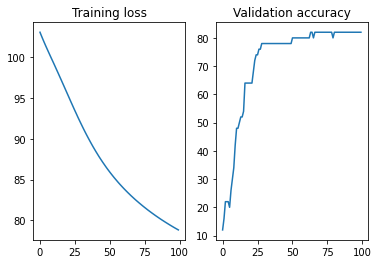

In [13]:
# BONUS WORK: Training with validation.
# The idea is to monitor the performance of the model (when training) on another subset (called the "validation set").
# This helps avoiding overfitting and allows to stop training when the performance peaks.
# To do that, at each epoch we compute the accuracy of the model on the validation set, and check if it increases:
# in the end, we keep the model with maximum performance

# First we define the validation set by splitting the training data into 2 subsets (90% training and 10% validation)
# We also define the corresponding dataloaders
n_train_examples = int(len(train_data)*0.9)
n_valid_examples = len(train_data) - n_train_examples
train_data, valid_data = random_split(train_data, [n_train_examples, n_valid_examples])
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_dataloader = DataLoader(test_data, batch_size=batch_size)

# TO DO: write the training function with validation
# - the overall training procedure is similar to what was done before
# - at the end of each epoch, we compute the accuracy of the model on the validation subset using the evaluation function
# - then, we check if this accuracy is increasing: if so, then we save the current model as the "best" or "optimal" model.
# Then, perform training with validation and display the training loss and validation accuracy

def train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device='cpu'):

    # First, copy the model to the device and set it in 'training' mode (thus all gradients are computed)
    model = model.to(device)
    model.train()
    
    # Define the optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    # Initialize a list to record the training loss and validation accuracy over epochs
    loss_all_epochs = []
    accuracy_val_all_epochs = []
    
    # Initialize the "optimal" accuracy, which will be used for performing validation
    accuracy_opt = 0
    
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        
        # Iterate over batches (using the dataloader)
        for batch_index, (images, labels) in enumerate(train_dataloader):
            
            # Vectorize the images and copy the data to the device
            images = images.reshape(-1, input_size)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            labels_predicted = model(images)
            loss = loss_fn(labels_predicted, labels)
            
            # Gradient descent
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Add the batch loss to the current epoch loss
            loss_current_epoch += loss.item()

        # At the end of each epoch, record the loss over all batches and the accuracy on the validation set
        loss_all_epochs.append(loss_current_epoch)
        accuracy_current_epoch = eval_mlp_classifier(model, valid_dataloader, device)
        accuracy_val_all_epochs.append(accuracy_current_epoch)
        
        # Display the training loss and validation accuracy
        print('Epoch [{}/{}], Training loss: {:.4f} ; Validation accuracy: {:.4f}'
               .format(epoch+1, num_epochs, loss_current_epoch, accuracy_current_epoch))
            
        # Now record the model if the accuracy is higher than the "optimal" value
        if accuracy_current_epoch > accuracy_opt:
            model_opt = model
            accuracy_opt = accuracy_current_epoch

    return model_opt, loss_all_epochs, accuracy_val_all_epochs

# Instanciate and train an MLP classifier model
model = MLPClassif(input_size, hidden_size, num_classes, act_fn)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 100
learning_rate = 0.01
model, loss_all_epochs, accuracy_validation = train_val_mlp_classifier(model, train_dataloader, valid_dataloader, num_epochs, loss_fn, learning_rate, device)

# Display the (training) loss and (validation) accuracy over epochs
plt.figure()
plt.subplot(1, 2, 1)
plt.plot(loss_all_epochs)
plt.title('Training loss')
plt.subplot(1, 2, 2)
plt.plot(accuracy_validation)
plt.title('Validation accuracy')
plt.show()